In [27]:
# cv_analysis.ipynb

import json
import os
import sys
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

PROJECT_ROOT = Path("..").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.dataloader import (
    ForgeryDataset,
    detection_collate_fn,
    get_val_transform,
)
from src.models.mask2former_v2 import Mask2FormerForgeryModel
from src.utils.config_utils import load_yaml, sanitize_model_kwargs
from src.training.train_cv import build_solution_df
from src.data.dataloader import ForgeryDataset
from src.models.kaggle_metric import score as kaggle_score

plt.style.use("ggplot")

In [28]:
# -----------------
# Constants / Paths
# -----------------

OOF_ROOT = PROJECT_ROOT / "experiments" / "oof_results"
FULL_TRAIN_ROOT = PROJECT_ROOT / "experiments" / "full_train_results"

CLS_THRESHOLD_PATH = (
    PROJECT_ROOT / "experiments" / "cls_threshold_sweep" / "cls_threshold_sweep.csv"
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CFG_PATH = PROJECT_ROOT / "config" / "base.yaml"

CLPSE_ROOT = PROJECT_ROOT / "experiments" / "cls_collapse"

SAMPLEDUMP_ROOT = PROJECT_ROOT / "experiments" / "oof_results"

### OOF CV results

In [29]:
# List what's in experiments/oof_results/
oof_items = list(OOF_ROOT.iterdir())
oof_dirs = sorted([p.name for p in oof_items if p.is_dir()])
oof_files = sorted([p.name for p in oof_items if p.is_file()])

print("OOF dirs:", oof_dirs)
if oof_files:
    print("OOF loose files:", oof_files)


OOF dirs: ['anti_collapse_wcls2_strong_auth_penalty', 'auth_penalty_maskmass_only_w3', 'balanced_soft_penalty_thr0p3_temp0p3', 'base_wgroupkfold', 'cls_unclamp_test', 'gate_pass_TRUE', 'inf_thresh_off', 'loss_dice_heavy_bce0p5_dice2', 'mask_first_wmask4_wcls0p25', 'match_bce_dominant_cost2_dice0p5', 'match_dice_dominant_cost2_bce0p5', 'mini_ext_authpen_0p1', 'mini_ext_authpen_20', 'mini_ext_presence_w5', 'mini_lossv2_authpen_strong20', 'mini_lossv2_authpen_weak1', 'mini_lossv2_baseline', 'mini_lossv2_cls_up2', 'mini_lossv2_numq8_authpen10', 'mini_minmass_0p002', 'mini_presence_0p3', 'mini_presence_0p45_topk1', 'mini_presence_0p5', 'mini_qscore_0p15_minmass_0p002', 'mini_qscore_0p5', 'mini_smoke', 'mini_topk1_minmass_0p001', 'mini_topk1_minmass_0p003', 'mini_topk2_minmass_0p002', 'mini_topk_1', 'oof_lossv2_authpen_weak1_e25', 'oof_lossv2_cls_up2_authpen_weak1_e25', 'oof_lossv2_cls_up2_e25', 'sharp_auth_penalty_temp0p05_thr0p6_w2', 'soft_auth_penalty_temp1_thr0p2_w3']
OOF loose files: ['

In [33]:
def load_run(names):
    """
    names:
      - str: dir name under OOF_ROOT OR filename under OOF_ROOT
      - list/tuple[str]: load multiple; returns dict keyed by run/filename
    """
    if isinstance(names, (list, tuple)):
        return {str(n): load_run(str(n)) for n in names}

    name = str(names)
    p = OOF_ROOT / name

    # Case A: run directory
    if p.is_dir():
        run_dir = p
        oof_csv = run_dir / "oof_predictions.csv"
        metrics_json = run_dir / "oof_metrics.json"

        oof_df = pd.read_csv(oof_csv) if oof_csv.exists() else None
        metrics = json.load(metrics_json.open()) if metrics_json.exists() else None

        fold_files = sorted(run_dir.glob("fold_*_oof.csv"))
        fold_dfs = {f.stem: pd.read_csv(f) for f in fold_files}

        return {"name": run_dir.name, "path": run_dir, "oof": oof_df, "metrics": metrics, "folds": fold_dfs}

    # Case B: loose file
    if p.is_file():
        if p.suffix.lower() == ".csv":
            return {"name": p.name, "path": p, "oof": pd.read_csv(p), "metrics": None, "folds": {}}
        if p.suffix.lower() == ".json":
            return {"name": p.name, "path": p, "oof": None, "metrics": json.load(p.open()), "folds": {}}
        raise ValueError(f"Unsupported file type: {p.suffix}")

    raise FileNotFoundError(f"Not found under OOF_ROOT: {name}")

# Use load_run(name | [names]) to load one or more CV runs or loose files from experiments/oof_results/
runs = load_run(["oof_lossv2_cls_up2_authpen_weak1_e25"])  # or: load_run("mini_smoke"), load_run("oof_predictions.csv")

print("Loaded:")
if isinstance(runs, dict) and "name" not in runs:
    for k, v in runs.items():
        print(f" - {v['name']} ({v['path']})")
else:
    print(f" - {runs['name']} ({runs['path']})")



Loaded:
 - oof_lossv2_cls_up2_authpen_weak1_e25 (C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\oof_lossv2_cls_up2_authpen_weak1_e25)


=== Loaded runs ===

oof_lossv2_cls_up2_authpen_weak1_e25
  Mean CV   : 0.18052878220948618
  OOF score : 0.1805358260260567
  Folds     : [0.21698757677842528, 0.129555247968704, 0.19504352188132928]


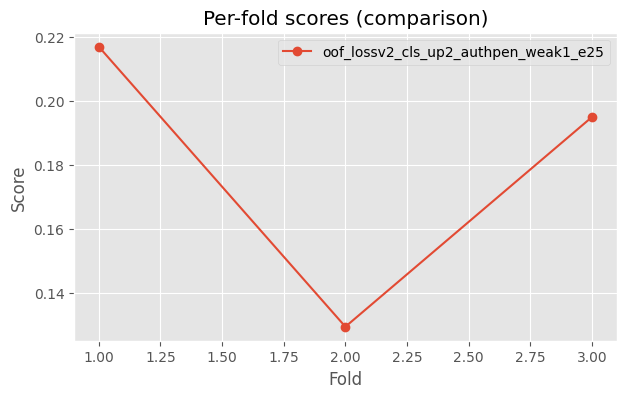

In [34]:
def show_run_metrics(names):
    """
    Pass a run dir name (str) or list of names to compare.
    """
    runs = load_run(names)
    if isinstance(runs, dict) and "name" not in runs:
        items = list(runs.values())
    else:
        items = [runs]

    # Clean summary header
    print("=== Loaded runs ===")
    for r in items:
        m = r["metrics"] or {}
        mean_cv = m.get("mean_cv", None)
        oof_score = m.get("oof_score", None)
        fold_scores = m.get("fold_scores", None)

        print(f"\n{r['name']}")
        print(f"  Mean CV   : {mean_cv}")
        print(f"  OOF score : {oof_score}")
        if fold_scores is not None:
            print(f"  Folds     : {fold_scores}")

    # Comparison plot (only for runs that have fold_scores)
    plot_items = [(r["name"], (r["metrics"] or {}).get("fold_scores")) for r in items]
    plot_items = [(n, fs) for (n, fs) in plot_items if fs is not None]

    if plot_items:
        plt.figure(figsize=(7, 4))
        for name, fs in plot_items:
            plt.plot(range(1, len(fs) + 1), fs, marker="o", label=name)
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.title("Per-fold scores (comparison)")
        plt.legend()
        plt.show()

    return runs

# Single run
_ = show_run_metrics("oof_lossv2_cls_up2_authpen_weak1_e25")

# Compare multiple runs
# _ = show_run_metrics(["mini_smoke", "some_other_run"])



## CollapseLogger

In [35]:
# ---- Use an already-loaded run from `runs` ----
run = runs["oof_lossv2_cls_up2_authpen_weak1_e25"]  # must exist in `runs`

OOF_RUN_DIR = Path(run["path"])
oof_metrics = run["metrics"] or {}
oof_predictions = run["oof"]
fold_dfs = run["folds"]

print("\n== oof_predictions.csv (head) ==")
display(oof_predictions.head() if oof_predictions is not None else None)

print("\nFound fold CSVs:", list(fold_dfs.keys()))


== oof_predictions.csv (head) ==


,row_id,annotation
0,10,"[1, 5648, 5697, 376, 6137, 24, 6209, 376, 6649..."
1,10015,"[90489, 19, 91689, 19, 92889, 19, 94089, 19, 9..."
2,10017,"[65, 28, 145, 8, 157, 24, 321, 28, 401, 8, 413..."
3,10030,"[406574, 20, 407240, 20, 407906, 20, 408572, 2..."
4,10070,"[143214, 22, 143926, 22, 144638, 22, 145350, 2..."



Found fold CSVs: ['fold_1_oof', 'fold_2_oof', 'fold_3_oof']


In [36]:
# Rebuild solution_df and re-score to match train_cv additional pipeline verification
full_dataset = ForgeryDataset(transform=None)
solution_df = build_solution_df(full_dataset)

# Overall OOF score (ALIGN BY row_id, then score)
solution_df["row_id"] = solution_df["row_id"].astype(str)
oof_predictions["row_id"] = oof_predictions["row_id"].astype(str)

sub_aligned = (
    solution_df[["row_id"]]
    .merge(oof_predictions[["row_id", "annotation"]], on="row_id", how="left")
)

recomputed_oof = kaggle_score(
    solution_df[["row_id", "annotation", "shape"]].copy(),
    sub_aligned[["row_id", "annotation"]].copy(),
    row_id_column_name="row_id",
)

print("\n== Recomputed overall OOF score ==")
print("recomputed_oof:", float(recomputed_oof))

# Per-fold (recompute using the saved fold CSVs if present)
def fold_num_from_stem(stem: str) -> int:
    m = re.search(r"(\d+)", stem)
    return int(m.group(1)) if m else -1

if fold_dfs:
    # Build stable (row_id, occ) keys on the FULL solution_df once
    sol = solution_df.copy()
    sol["row_id"] = sol["row_id"].astype(str)
    sol["occ"] = sol.groupby("row_id").cumcount()

    fold_scores = []
    for stem, fdf in sorted(fold_dfs.items(), key=lambda kv: fold_num_from_stem(kv[0])):
        fnum = fold_num_from_stem(stem)

        sub = fdf.copy()
        sub["row_id"] = sub["row_id"].astype(str)
        # IMPORTANT: occ must follow the fold CSV order (this is what we’ll score)
        sub["occ"] = sub.groupby("row_id").cumcount()

        # Rebuild fold solution IN THE SAME ORDER AS sub (no sorting, no isin)
        fold_sol = sub[["row_id", "occ"]].merge(
            sol[["row_id", "occ", "annotation", "shape"]],
            on=["row_id", "occ"],
            how="left",
        )

        # Hard sanity checks (if these fail, your saved fold CSV isn't compatible with solution_df)
        assert len(fold_sol) == len(sub)
        if fold_sol["annotation"].isna().any() or fold_sol["shape"].isna().any():
            bad = fold_sol[fold_sol["annotation"].isna() | fold_sol["shape"].isna()].head(10)
            raise RuntimeError(f"{stem}: fold_sol has missing GT rows. Sample:\n{bad}")

        # Submission already in correct order; kaggle_score aligns by row order
        fold_sub = sub[["row_id", "annotation"]].copy()

        s = kaggle_score(
            fold_sol[["row_id", "annotation", "shape"]].copy(),
            fold_sub.copy(),
            row_id_column_name="row_id",
        )
        fold_scores.append((fnum, float(s)))

    fold_scores_df = pd.DataFrame(fold_scores, columns=["fold", "kaggle_metric"]).sort_values("fold")
    print("\n== Recomputed per-fold scores ==")
    display(fold_scores_df)


== Recomputed overall OOF score ==
recomputed_oof: 0.032215389829571665

== Recomputed per-fold scores ==


,fold,kaggle_metric
0,1,0.216988
1,2,0.129555
2,3,0.195044


In [37]:
# ---------------------------------------------------------------------
# Load ClsCollapseLogger outputs for the CV folds
# (stored under experiments/oof_results/<run_name>/cv_fold*/ and cv_oof_summary/)
# ---------------------------------------------------------------------

def _read_json(p: Path):
    with open(p, "r") as f:
        return json.load(f)

def _read_jsonl(p: Path):
    rows = []
    with open(p, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows) if rows else pd.DataFrame()

def _read_table(p: Path):
    suf = p.suffix.lower()
    if suf == ".csv":
        return pd.read_csv(p)
    if suf in (".jsonl", ".ndjson"):
        return _read_jsonl(p)
    return None

LOGGER_FILES = {
    "debug.jsonl",
    "epoch_summary.csv",
    "meta.json",
    "optimizer.json",
    "step_losses.csv",
}

# Discover fold directories (cv_fold1, cv_fold2, ...) + optional cv_oof_summary
fold_dirs = []
if OOF_RUN_DIR.exists():
    for d in sorted(OOF_RUN_DIR.iterdir()):
        if d.is_dir() and (re.match(r"cv_fold\d+$", d.name) or d.name == "cv_oof_summary"):
            fold_dirs.append(d)

collapse_json = {}    # (fold_dirname, filename) -> dict
collapse_tables = {}  # (fold_dirname, filename) -> df

for d in fold_dirs:
    for fname in LOGGER_FILES:
        p = d / fname
        if not p.exists():
            continue

        if p.suffix.lower() == ".json":
            try:
                collapse_json[(d.name, fname)] = _read_json(p)
            except Exception:
                pass
        elif p.suffix.lower() in (".csv", ".jsonl", ".ndjson"):
            try:
                df = _read_table(p)
                if df is not None and len(df) > 0:
                    collapse_tables[(d.name, fname)] = df
            except Exception:
                pass

print("Loaded ClsCollapseLogger artifacts from:")
for d in fold_dirs:
    print(" ", d)

print(f"  JSON blobs : {len(collapse_json)}")
print(f"  Tables     : {len(collapse_tables)}")

if collapse_tables:
    by_dir = {}
    for (dname, fname), df in collapse_tables.items():
        by_dir.setdefault(dname, []).append((fname, df))

    for dname in sorted(by_dir):
        print(f"\n{dname} tables:")
        for fname, df in sorted(by_dir[dname], key=lambda x: x[0]):
            print(f"  - {fname} | shape={df.shape} | cols={list(df.columns)}")


Loaded ClsCollapseLogger artifacts from:
  C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\oof_lossv2_cls_up2_authpen_weak1_e25\cv_fold1
  C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\oof_lossv2_cls_up2_authpen_weak1_e25\cv_fold2
  C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\oof_lossv2_cls_up2_authpen_weak1_e25\cv_fold3
  C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\oof_lossv2_cls_up2_authpen_weak1_e25\cv_oof_summary
  JSON blobs : 6
  Tables     : 10

cv_fold1 tables:
  - debug.jsonl | shape=(301954, 63) | cols=['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'per_image', 'mask_probs', 'class_probs', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'allowed_q', 'matched', 'reason', 'B', 'pos', 'total', 'pos_frac', 'weights_sum', 'weights_mean', 'presence_mean', 'presence_min', 'presence_max', 'loss_presence', 'prese

In [ ]:
# Convenience: key summaries across ALL loaded debug tables

def concat_tables(name_contains: str):
    dfs = []
    for (fold_key, fname), df in collapse_tables.items():
        if name_contains.lower() in fname.lower():
            d = df.copy()
            m = re.search(r"(\d+)", str(fold_key))
            d["fold"] = int(m.group(1)) if m else fold_key  # cv_oof_summary stays as string
            d["_source"] = fname
            dfs.append(d)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


step_losses = concat_tables("step")
epoch_summary = concat_tables("epoch")
debug_events = concat_tables("debug")

if len(step_losses):
    display(step_losses.describe(include="all"))


,fold,epoch,global_step,lr,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_presence,loss_auth_penalty,loss_total,w_mask_cls,w_presence,w_auth_penalty,train_topk,train_min_mask_mass,few_queries_lambda,presence_lse_beta,_source
count,64725.000000,64725.000000,64725.000000,6.472500e+04,64725.000000,64725.000000,64725.000000,64725.000000,64725.000000,64725.000000,64725.0,64725.0,64725.0,64725.0,6.472500e+04,6.472500e+04,64725.0,64725
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,step_losses.csv
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64725
mean,2.000000,13.000000,10787.000000,1.000000e-04,0.310516,0.745509,0.498729,1.099827,0.013820,3.216599,2.0,1.0,1.0,2.0,1.000000e-03,1.000000e-01,10.0,NaN
std,0.816503,7.211158,6228.214135,2.710526e-20,0.329115,0.242005,0.145361,0.788796,0.012046,0.853073,0.0,0.0,0.0,0.0,6.505263e-19,1.387790e-17,0.0,NaN
min,1.000000,1.000000,0.000000,1.000000e-04,-0.000000,-0.000000,0.000000,0.000001,0.000000,0.000001,2.0,1.0,1.0,2.0,1.000000e-03,1.000000e-01,10.0,NaN
25%,1.000000,7.000000,5393.000000,1.000000e-04,0.184798,0.660113,0.412201,0.666896,0.005463,2.805620,2.0,1.0,1.0,2.0,1.000000e-03,1.000000e-01,10.0,NaN
50%,2.000000,13.000000,10787.000000,1.000000e-04,0.285838,0.810492,0.492221,0.980698,0.011385,3.216248,2.0,1.0,1.0,2.0,1.000000e-03,1.000000e-01,10.0,NaN
75%,3.000000,19.000000,16181.000000,1.000000e-04,0.401725,0.921236,0.578559,1.379670,0.019410,3.597664,2.0,1.0,1.0,2.0,1.000000e-03,1.000000e-01,10.0,NaN


In [40]:
# Epoch-aggregated losses (mean over steps, per fold × epoch)
# Updated to match collapse_logger.log_step_losses payload (loss_presence, w_presence, + train knobs)

loss_cols = [
    "loss_mask_bce",
    "loss_mask_dice",
    "loss_mask_cls",
    "loss_presence",
    "loss_auth_penalty",
    "loss_total",
]

# (optional but useful) epoch-constant knobs / weights to aggregate too
meta_cols = [
    "w_mask_cls",
    "w_presence",
    "w_auth_penalty",
    "train_topk",
    "train_min_mask_mass",
    "few_queries_lambda",
    "presence_lse_beta",
]

cols = [c for c in (loss_cols + meta_cols) if c in step_losses.columns]

epoch_losses = (
    step_losses
    .groupby(["fold", "epoch"], as_index=False)[cols]
    .mean()
    .sort_values(["fold", "epoch"])
)

display(epoch_losses)


,fold,epoch,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_presence,loss_auth_penalty,loss_total,w_mask_cls,w_presence,w_auth_penalty,train_topk,train_min_mask_mass,few_queries_lambda,presence_lse_beta
0,1,1,0.407937,0.825026,0.594661,1.344462,0.024248,3.870088,2.0,1.0,1.0,2.0,0.001,0.1,10.0
1,1,2,0.368904,0.808481,0.574134,1.231361,0.020726,3.647260,2.0,1.0,1.0,2.0,0.001,0.1,10.0
2,1,3,0.334583,0.791110,0.546058,1.161948,0.018502,3.460578,2.0,1.0,1.0,2.0,0.001,0.1,10.0
3,1,4,0.323764,0.789866,0.532816,1.141793,0.016952,3.396384,2.0,1.0,1.0,2.0,0.001,0.1,10.0
4,1,5,0.318889,0.777187,0.532457,1.143835,0.016510,3.378649,2.0,1.0,1.0,2.0,0.001,0.1,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,3,21,0.291118,0.763312,0.521120,1.091111,0.013011,3.249529,2.0,1.0,1.0,2.0,0.001,0.1,10.0
71,3,22,0.291577,0.753193,0.518273,1.100211,0.013010,3.242660,2.0,1.0,1.0,2.0,0.001,0.1,10.0
72,3,23,0.296144,0.749786,0.519641,1.094558,0.012776,3.240298,2.0,1.0,1.0,2.0,0.001,0.1,10.0
73,3,24,0.292971,0.756273,0.519412,1.079054,0.012367,3.226629,2.0,1.0,1.0,2.0,0.001,0.1,10.0


In [42]:
# --- Useful, compact diagnostics for epoch_summary ---

es = epoch_summary.copy()

num_cols = [
    "epoch_loss",
    # qscore-focused signals
    "qscore_max_mean", "qscore_max_p95", "qscore_max_over_sum_mean",
    "num_qscore_gt_0.05", "num_qscore_gt_0.10", "num_qscore_gt_0.20",
    # mask signals
    "mask_mass_max_mean", "mask_max_mean",
    # knobs/weights logged
    "w_mask_cls", "w_presence", "few_queries_lambda",
]
for c in num_cols:
    if c in es.columns:
        es[c] = pd.to_numeric(es[c], errors="coerce")

present_cols = [c for c in num_cols if c in es.columns]

last_epoch = (
    es.sort_values(["fold", "epoch"])
      .groupby("fold", as_index=False)
      .tail(1)
      .sort_values("fold")
)

# Per-fold last-epoch snapshot
display(
    last_epoch[["fold", "epoch"] + present_cols]
      .sort_values("fold")
      .reset_index(drop=True)
)

# Cross-fold mean/std at last epoch
agg = last_epoch[present_cols].agg(["mean", "std"]).T
agg.columns = ["mean", "std"]
display(agg.sort_values("mean"))

# Quick red-flag table at last epoch (qscore-era)
flags = last_epoch.assign(
    q_dead   = last_epoch.get("qscore_max_p95", np.nan) < 0.05,
    sparse_dead = last_epoch.get("num_qscore_gt_0.10", np.nan) < 0.5,   # ~no queries above 0.10 on avg
    mask_dead = last_epoch.get("mask_mass_max_mean", np.nan) < 0.01,    # masks never get any mass
    dominance_bad = last_epoch.get("qscore_max_over_sum_mean", np.nan) < 0.6,  # no single winner
).loc[:, ["fold", "epoch", "q_dead", "sparse_dead", "mask_dead", "dominance_bad"]]
display(flags)

# Trend vs epoch (pooled across folds): corr with epoch
trend_cols = ["epoch"] + present_cols
trend_corr = (
    es[trend_cols]
      .corr(numeric_only=True)["epoch"]
      .drop("epoch")
      .sort_values()
)
display(trend_corr.to_frame("corr_with_epoch"))


,fold,epoch,epoch_loss,qscore_max_mean,qscore_max_p95,qscore_max_over_sum_mean,num_qscore_gt_0.05,num_qscore_gt_0.10,num_qscore_gt_0.20,mask_mass_max_mean,mask_max_mean,w_mask_cls,w_presence,few_queries_lambda
0,1,25,3.122826,0.002941,0.005844,0.067024,0.0,0.00,0.0,0.038293,0.837488,2.0,1.0,0.1
1,2,25,2.299850,0.185046,0.358027,0.905793,1.0,0.75,0.5,0.295917,0.759146,2.0,1.0,0.1
2,3,25,3.259189,0.007472,0.011360,0.066669,0.0,0.00,0.0,0.051049,0.952716,2.0,1.0,0.1


,mean,std
qscore_max_mean,0.065153,1.038551e-01
few_queries_lambda,0.100000,1.699675e-17
qscore_max_p95,0.125077,2.017596e-01
mask_mass_max_mean,0.128420,1.451971e-01
num_qscore_gt_0.20,0.166667,2.886751e-01
num_qscore_gt_0.10,0.250000,4.330127e-01
num_qscore_gt_0.05,0.333333,5.773503e-01
qscore_max_over_sum_mean,0.346495,4.843657e-01
mask_max_mean,0.849783,9.736880e-02
w_presence,1.000000,0.000000e+00


,fold,epoch,q_dead,sparse_dead,mask_dead,dominance_bad
24,1,25,True,True,False,True
49,2,25,False,False,False,False
74,3,25,True,True,False,True


,corr_with_epoch
epoch_loss,-0.588075
mask_max_mean,-0.195587
num_qscore_gt_0.05,-0.158643
mask_mass_max_mean,0.173120
qscore_max_mean,0.229482
qscore_max_p95,0.306586
num_qscore_gt_0.20,0.307798
num_qscore_gt_0.10,0.337919
qscore_max_over_sum_mean,0.378679
w_mask_cls,NaN


In [43]:
# --- Load ALL debug events (UPDATED for current collapse logger + train_cv tags) ---

dbg = debug_events.copy() if "debug_events" in globals() else pd.DataFrame()
print("debug_events shape:", dbg.shape)
print("cols:", list(dbg.columns))

if len(dbg) == 0:
    raise ValueError("debug_events is empty")

# sanity check: OOF inference debug payload (per-fold, aggregated)
oof_raw = dbg[dbg["tag"].astype(str).eq("oof_inference_debug")]
show0 = [c for c in [
    "fold","val_samples",
    "masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep",
    "rates","max_cls_prob","max_mask_prob",
] if c in oof_raw.columns]
display(oof_raw[show0].head(10))

# ---------- helpers ----------
def _to_bool(s):
    if s.dtype == object:
        return s.astype(str).str.lower().isin(["true", "1", "yes"])
    return s.astype(bool)

def _safe_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _flatten_dict_col(df, col, prefix=None):
    """Flatten a dict-valued column into separate columns, preserving row alignment."""
    if col not in df.columns:
        return df
    pfx = prefix or col

    ser = df[col]
    mask = ser.apply(lambda x: isinstance(x, dict))
    if not mask.any():
        return df

    flat = pd.json_normalize(ser[mask])
    flat.index = ser[mask].index  # align with original rows
    flat.columns = [f"{pfx}.{k}" for k in flat.columns]

    df = df.drop(columns=[col])
    df = df.join(flat, how="left")
    return df

def p95(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(x.quantile(0.95)) if len(x) else np.nan

# ---------- flatten nested dict payloads ----------
# train_cv emits nested dicts for these tags
for col in ["rates", "mask_probs", "class_probs", "img_probs", "max_cls_prob", "max_mask_prob", "batch", "per_image"]:
    dbg = _flatten_dict_col(dbg, col)

# ---------- coerce numerics (aligned to current emitted keys) ----------
dbg = _safe_num(
    dbg,
    [
        # common
        "fold","epoch","global_step","b","i","B","Q","Hm","Wm",
        "img_label","val_samples",

        # oof_inference_debug counts
        "masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep",

        # oof_inference_debug flattened
        "rates.masks_empty","rates.gate_fail","rates.num_keep0","rates.cls_filtered_all_fg","rates.no_fg_pre_keep",
        "max_cls_prob.mean","max_cls_prob.p95","max_cls_prob.max",
        "max_mask_prob.mean","max_mask_prob.p95","max_mask_prob.max",

        # batch_target0 / mask_target_sanity / debug_probs
        "masks_sum",
        "mask_probs.mean","mask_probs.p95","mask_probs.max","mask_probs.frac_gt_0p5",
        "class_probs.mean","class_probs.max","class_probs.frac_gt_0p1",

        # hungarian matching
        "tgt_numel","tgt_sum","allowed_q","matched","num_gt","Qa",

        # loss_cls_targets
        "pos","total","pos_frac","weights_sum","weights_mean",

        # loss_presence_stats (from compute_losses)
        "presence_mean","presence_min","presence_max","loss_presence","presence_lse_beta",

        # sparsity_metrics (from compute_losses)
        "train_topk","train_min_mask_mass",
        "batch.allowed_mean","batch.qmax_over_sum_mean","batch.mask_mass_max_mean",

        # train_fg_prob_per_query (from compute_losses)
        "fg_prob_mean","fg_prob_p95","fg_prob_max",

        # loss_auth_penalty_stats (from compute_losses)
        "authentic_frac","per_image_penalty_mean","loss_auth_penalty","few_queries_lambda","loss_few_queries",

        # oof_pred_area_stats (from train_cv)
        "pred_auth_frac","pred_non_auth_count","pred_non_auth_area_ratio_mean",
    ],
)

# bool-ish flags (only include if present in your dbg)
for c in ["gate_pass","any_fg_pre_keep","any_fg_post_keep"]:
    if c in dbg.columns:
        dbg[c] = _to_bool(dbg[c])


# ---------- OOF inference debug summary (tag == oof_inference_debug) ----------
print("\n=== OOF inference debug summary (per fold) ===")
oof = dbg[dbg["tag"].astype(str).eq("oof_inference_debug")].copy()
if len(oof):
    show_cols = [c for c in [
        "fold","val_samples",
        "masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep",
        "rates.masks_empty","rates.gate_fail","rates.num_keep0","rates.cls_filtered_all_fg","rates.no_fg_pre_keep",
        "max_cls_prob.mean","max_cls_prob.p95","max_cls_prob.max",
        "max_mask_prob.mean","max_mask_prob.p95","max_mask_prob.max",
    ] if c in oof.columns]
    display(oof.sort_values("fold")[show_cols])

    # global weighted failure rates across folds
    print("\n=== OOF inference debug summary (global weighted failure rates) ===")
    denom = oof["val_samples"].astype(float).replace(0, np.nan)
    global_rates = {}
    for k in ["masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep"]:
        if k in oof.columns:
            global_rates[k] = float(oof[k].astype(float).sum() / denom.sum())
    display(pd.Series(global_rates, name="weighted_rate").to_frame())


# ---------- Presence stats (tag == loss_presence_stats) ----------
print("\n=== Presence stats (loss_presence_stats: last epoch per fold + mean/std) ===")
pres = dbg[dbg["tag"].astype(str).eq("loss_presence_stats")].copy()
if len(pres):
    cols = [c for c in [
        "fold","epoch","presence_mean","presence_min","presence_max","loss_presence","presence_lse_beta"
    ] if c in pres.columns]
    per_fold_last = (pres.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))
    display(per_fold_last.drop(columns=["fold","epoch"], errors="ignore").agg(["mean","std"]).T)


# ---------- Auth penalty + few-queries stats (tag == loss_auth_penalty_stats) ----------
print("\n=== Auth penalty + few-queries stats (loss_auth_penalty_stats: last epoch per fold + mean/std) ===")
ap = dbg[dbg["tag"].astype(str).eq("loss_auth_penalty_stats")].copy()
if len(ap):
    cols = [c for c in [
        "fold","epoch","authentic_frac","per_image_penalty_mean","loss_auth_penalty",
        "few_queries_lambda","loss_few_queries"
    ] if c in ap.columns]
    per_fold_last = (ap.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))
    display(per_fold_last.drop(columns=["fold","epoch"], errors="ignore").agg(["mean","std"]).T)


# ---------- Class target balance (tag == loss_cls_targets) ----------
print("\n=== Class-target balance (loss_cls_targets) ===")
ct = dbg[dbg["tag"].astype(str).eq("loss_cls_targets")].copy()
if len(ct):
    cols = [c for c in ["fold","epoch","B","Q","pos","total","pos_frac","weights_sum","weights_mean"] if c in ct.columns]
    display(
        ct[cols]
          .groupby("fold", dropna=False)[[c for c in cols if c not in ("fold","epoch","B","Q")]]
          .agg(["mean","std","min","max"])
    )


# ---------- Hungarian matching health (tags == hungarian_match_*) ----------
print("\n=== Hungarian matching input health (hungarian_match_input) ===")
hm_in = dbg[dbg["tag"].astype(str).eq("hungarian_match_input")].copy()
hm_out = dbg[dbg["tag"].astype(str).eq("hungarian_match_result")].copy()

if len(hm_in):
    cols = [c for c in ["fold","epoch","b","Q","Hm","Wm","tgt_shape","tgt_numel","tgt_sum","allowed_q"] if c in hm_in.columns]
    display(hm_in[cols].describe(include="all"))

if len(hm_out):
    print("\n=== Hungarian matching results (hungarian_match_result) ===")
    cols = [c for c in ["fold","epoch","b","matched","num_gt","Q","Qa","reason","cost_shape.0","cost_shape.1"] if c in hm_out.columns]
    if "reason" in hm_out.columns:
        display(hm_out.groupby(["fold","reason"], dropna=False).size().rename("rows").reset_index())
    if "matched" in hm_out.columns:
        display(hm_out.groupby("fold")["matched"].agg(["mean","std","min","max"]))


# ---------- Sparsity metrics (tag == sparsity_metrics) ----------
print("\n=== Sparsity metrics (sparsity_metrics: last epoch per fold + mean/std) ===")
sp = dbg[dbg["tag"].astype(str).eq("sparsity_metrics")].copy()
if len(sp):
    cols = [c for c in [
        "fold","epoch","train_topk","train_min_mask_mass",
        "batch.allowed_mean","batch.qmax_over_sum_mean","batch.mask_mass_max_mean",
    ] if c in sp.columns]
    per_fold_last = (sp.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))
    display(per_fold_last.drop(columns=["fold","epoch"], errors="ignore").agg(["mean","std"]).T)


# ---------- Mask-head “alive” signal during training (tag == train_fg_prob_per_query) ----------
print("\n=== Mask-head liveness during training (train_fg_prob_per_query: last epoch) ===")
fgq = dbg[dbg["tag"].astype(str).eq("train_fg_prob_per_query")].copy()
if len(fgq):
    cols = [c for c in ["fold","epoch","Q","fg_prob_mean","fg_prob_p95","fg_prob_max"] if c in fgq.columns]
    per_fold_last = (fgq.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))

    # fg_prob_per_query is list -> explode if present
    if "fg_prob_per_query" in fgq.columns:
        last = fgq.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1)
        s = last[["fold","epoch","fg_prob_per_query"]].dropna().explode("fg_prob_per_query")
        s["fg_prob_per_query"] = pd.to_numeric(s["fg_prob_per_query"], errors="coerce")
        print("\n=== Mask-head per-query foreground distribution (last epoch, exploded) ===")
        display(
            s.groupby("fold")["fg_prob_per_query"]
             .agg(mean="mean", p95=p95, max="max")
             .reset_index()
             .sort_values("fold")
        )


# ---------- One-time logits/prob snapshots (tag == debug_probs) ----------
print("\n=== One-time logits/probability sanity snapshots (debug_probs) ===")
dp = dbg[dbg["tag"].astype(str).eq("debug_probs")].copy()
if len(dp):
    cols = [c for c in dp.columns if c.startswith(("mask_probs.","class_probs.","img_probs."))]
    show = [c for c in ["fold","epoch","global_step"] if c in dp.columns] + cols
    display(dp.sort_values([c for c in ["fold","epoch","global_step"] if c in dp.columns]).head(20)[show])


# ---------- OOF pred distribution + area stats (tag == oof_pred_area_stats) ----------
print("\n=== OOF prediction distribution + area stats (oof_pred_area_stats) ===")
oa = dbg[dbg["tag"].astype(str).eq("oof_pred_area_stats")].copy()
if len(oa):
    cols = [c for c in ["fold","val_samples","pred_auth_frac","pred_non_auth_count","pred_non_auth_area_ratio_mean"] if c in oa.columns]
    display(oa.sort_values([c for c in ["fold"] if c in oa.columns])[cols])


debug_events shape: (905963, 64)
cols: ['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'per_image', 'mask_probs', 'class_probs', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'allowed_q', 'matched', 'reason', 'B', 'pos', 'total', 'pos_frac', 'weights_sum', 'weights_mean', 'presence_mean', 'presence_min', 'presence_max', 'loss_presence', 'presence_lse_beta', 'train_topk', 'train_min_mask_mass', 'allowed_queries_per_image', 'qscore_max', 'qscore_sum', 'qscore_max_over_sum', 'mask_mass_max', 'batch', 'fg_prob_per_query', 'fg_prob_mean', 'fg_prob_p95', 'fg_prob_max', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'few_queries_lambda', 'loss_few_queries', 'cost_shape', 'num_gt', 'Qa', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'no_fg_pre_keep', 'rates', 'max_cls_prob', 'max_mask_prob', 'pred_auth_frac', 'pred_non_auth_count', 'pred_non_auth_area_ratio_mean', '_source']


,fold,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,no_fg_pre_keep,rates,max_cls_prob,max_mask_prob
301952,1,1726.0,30.0,0.0,30.0,0.0,189.0,"{'masks_empty': 0.01738122827346466, 'gate_fai...","{'mean': 0.07681334763765335, 'p95': 0.0768138...","{'mean': 0.8750499486923218, 'p95': 0.99999666..."
603956,2,1725.0,120.0,0.0,120.0,27.0,139.0,"{'masks_empty': 0.06956521739130435, 'gate_fai...","{'mean': 0.6723968982696533, 'p95': 0.67358940...","{'mean': 0.8971885442733765, 'p95': 1.0, 'max'..."
905960,3,1725.0,0.0,0.0,0.0,0.0,52.0,"{'masks_empty': 0.0, 'gate_fail': 0.0, 'num_ke...","{'mean': 0.14636604487895966, 'p95': 0.1463660...","{'mean': 0.8955227732658386, 'p95': 0.99992275..."



=== OOF inference debug summary (per fold) ===


,fold,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,no_fg_pre_keep,rates.masks_empty,rates.gate_fail,rates.num_keep0,rates.cls_filtered_all_fg,rates.no_fg_pre_keep,max_cls_prob.mean,max_cls_prob.p95,max_cls_prob.max,max_mask_prob.mean,max_mask_prob.p95,max_mask_prob.max
301952,1.0,1726.0,30.0,0.0,30.0,0.0,189.0,0.017381,0.0,0.017381,0.000000,0.109502,0.076813,0.076814,0.076814,0.875050,0.999997,1.000000
603956,2.0,1725.0,120.0,0.0,120.0,27.0,139.0,0.069565,0.0,0.069565,0.015652,0.080580,0.672397,0.673589,0.673594,0.897189,1.000000,1.000000
905960,3.0,1725.0,0.0,0.0,0.0,0.0,52.0,0.000000,0.0,0.000000,0.000000,0.030145,0.146366,0.146366,0.146366,0.895523,0.999923,0.999997



=== OOF inference debug summary (global weighted failure rates) ===


,weighted_rate
masks_empty,0.028980
gate_fail,0.000000
num_keep0,0.028980
cls_filtered_all_fg,0.005216
no_fg_pre_keep,0.073416



=== Presence stats (loss_presence_stats: last epoch per fold + mean/std) ===


,fold,epoch,presence_mean,presence_min,presence_max,loss_presence,presence_lse_beta
301948,1.0,25.0,0.153276,0.068686,0.237865,1.474919,10.0
603952,2.0,25.0,0.486748,0.230641,0.623679,0.813338,10.0
905956,3.0,25.0,0.159525,0.031258,0.313145,1.949915,10.0


,mean,std
presence_mean,0.266516,0.190752
presence_min,0.110195,0.105974
presence_max,0.391563,0.204512
loss_presence,1.412724,0.570835
presence_lse_beta,10.000000,0.000000



=== Auth penalty + few-queries stats (loss_auth_penalty_stats: last epoch per fold + mean/std) ===


,fold,epoch,authentic_frac,per_image_penalty_mean,loss_auth_penalty,few_queries_lambda,loss_few_queries
301951,1.0,25.0,0.500000,0.020213,0.013065,0.1,0.303201
603955,2.0,25.0,0.000000,0.040178,0.000000,0.1,0.602668
905959,3.0,25.0,0.333333,0.025910,0.010645,0.1,0.388653


,mean,std
authentic_frac,0.277778,2.545875e-01
per_image_penalty_mean,0.028767,1.028430e-02
loss_auth_penalty,0.007904,6.950797e-03
few_queries_lambda,0.100000,1.699675e-17
loss_few_queries,0.431507,1.542645e-01



=== Class-target balance (loss_cls_targets) ===


pos                          total                        pos_frac  \
          mean       std  min  max       mean       std   min   max      mean   
fold                                                                            
1.0   2.841530  1.476260  0.0  8.0  59.965238  1.020644  30.0  60.0  0.047382   
2.0   2.860440  1.483989  0.0  8.0  59.982619  0.510322  45.0  60.0  0.047685   
3.0   2.796477  1.520408  0.0  8.0  59.982619  0.510322  45.0  60.0  0.046620   

                              weights_sum                      weights_mean  \
           std  min       max        mean       std  min   max         mean   
fold                                                                          
1.0   0.024608  0.0  0.133333   10.038227  3.165466  0.0  21.0     0.167391   
2.0   0.024734  0.0  0.133333   10.022468  3.213174  1.5  21.0     0.167083   
3.0   0.025343  0.0  0.133333    9.869803  3.441238  0.0  21.0     0.164542   

                             
           std    min   max  
fold                         
1.0   0.052714  0.000  0.35  
2.0   0.053536  0.025  0.35  
3.0   0.057349  0.000  0.35


=== Hungarian matching input health (hungarian_match_input) ===


,fold,epoch,b,Q,Hm,Wm,tgt_shape,tgt_numel,tgt_sum,allowed_q
count,258800.000000,258800.000000,258800.000000,258800.0,258800.0,258800.0,258800,258800.000000,258800.000000,258800.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 256, 256]",NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,118850,NaN,NaN,NaN
mean,2.000097,13.000000,1.499517,15.0,64.0,64.0,NaN,49493.860896,1986.291924,1.965522
std,0.816478,7.211116,1.117950,0.0,0.0,0.0,NaN,55922.759045,3843.413167,0.242104
min,1.000000,1.000000,0.000000,15.0,64.0,64.0,NaN,0.000000,0.000000,0.000000
25%,1.000000,7.000000,0.000000,15.0,64.0,64.0,NaN,0.000000,0.000000,2.000000
50%,2.000000,13.000000,1.000000,15.0,64.0,64.0,NaN,65536.000000,212.000000,2.000000
75%,3.000000,19.000000,2.000000,15.0,64.0,64.0,NaN,65536.000000,2262.000000,2.000000



=== Hungarian matching results (hungarian_match_result) ===


,fold,reason,rows
0,1.0,empty_gt,39625
1,1.0,no_allowed_queries,15
2,1.0,NaN,46610
3,2.0,empty_gt,39600
4,2.0,no_allowed_queries,4
5,2.0,NaN,46671
6,3.0,empty_gt,39625
7,3.0,no_allowed_queries,955
8,3.0,NaN,45695


,mean,std,min,max
fold,,,,
1.0,0.710794,0.739154,0.0,2.0
2.0,0.715317,0.743214,0.0,2.0
3.0,0.699322,0.741373,0.0,2.0



=== Sparsity metrics (sparsity_metrics: last epoch per fold + mean/std) ===


,fold,epoch,train_topk,train_min_mask_mass,batch.allowed_mean,batch.qmax_over_sum_mean,batch.mask_mass_max_mean
301949,1.0,25.0,2.0,0.001,2.0,0.456128,0.245239
603953,2.0,25.0,2.0,0.001,2.0,0.857641,0.765814
905957,3.0,25.0,2.0,0.001,2.0,0.360996,0.278748


,mean,std
train_topk,2.000000,0.000000
train_min_mask_mass,0.001000,0.000000
batch.allowed_mean,2.000000,0.000000
batch.qmax_over_sum_mean,0.558255,0.263603
batch.mask_mass_max_mean,0.429934,0.291363



=== Mask-head liveness during training (train_fg_prob_per_query: last epoch) ===


,fold,epoch,Q,fg_prob_mean,fg_prob_p95,fg_prob_max
301950,1.0,25.0,15.0,0.069483,0.170437,0.216940
603954,2.0,25.0,15.0,0.077963,0.352658,0.765814
905958,3.0,25.0,15.0,0.105286,0.148209,0.163300



=== Mask-head per-query foreground distribution (last epoch, exploded) ===


,fold,mean,p95,max
0,1.0,0.069483,0.170437,0.216940
1,2.0,0.077963,0.352658,0.765814
2,3.0,0.105286,0.148209,0.163300



=== One-time logits/probability sanity snapshots (debug_probs) ===


,fold,epoch,global_step,mask_probs.mean,mask_probs.p95,mask_probs.max,mask_probs.frac_gt_0p5,class_probs.mean,class_probs.max,class_probs.frac_gt_0p1
2,1.0,1.0,0.0,0.318666,0.905690,0.999982,0.274247,0.351825,0.404392,1.0
301956,2.0,1.0,0.0,0.072798,0.369959,0.999991,0.033879,0.617093,0.706293,1.0
603960,3.0,1.0,0.0,0.588462,0.995040,0.999995,0.599947,0.527064,0.603328,1.0



=== OOF prediction distribution + area stats (oof_pred_area_stats) ===


,fold,val_samples,pred_auth_frac,pred_non_auth_count,pred_non_auth_area_ratio_mean
301953,1.0,1726.0,0.017381,1696.0,0.041473
603957,2.0,1725.0,0.069565,1605.0,0.580539
905961,3.0,1725.0,0.000000,1725.0,0.044859
905962,NaN,5176.0,0.028980,5026.0,0.214781


In [44]:
# Explicit view of the 4 rates you care about (per fold + weighted mean)
oof = dbg[dbg["tag"].astype(str).eq("oof_inference_debug")].copy()

cols = ["fold","val_samples","rates.masks_empty","rates.num_keep0","rates.no_fg_pre_keep","rates.cls_filtered_all_fg"]
cols = [c for c in cols if c in oof.columns]
display(oof.sort_values("fold")[cols])

w = oof["val_samples"].astype(float).replace(0, np.nan)
rate_cols = [c for c in cols if c.startswith("rates.")]
weighted = {c: float((oof[c].astype(float) * w).sum() / w.sum()) for c in rate_cols}
display(pd.Series(weighted, name="weighted_rate").to_frame())


,fold,val_samples,rates.masks_empty,rates.num_keep0,rates.no_fg_pre_keep,rates.cls_filtered_all_fg
301952,1.0,1726.0,0.017381,0.017381,0.109502,0.000000
603956,2.0,1725.0,0.069565,0.069565,0.080580,0.015652
905960,3.0,1725.0,0.000000,0.000000,0.030145,0.000000


,weighted_rate
rates.masks_empty,0.028980
rates.num_keep0,0.028980
rates.no_fg_pre_keep,0.073416
rates.cls_filtered_all_fg,0.005216


In [46]:
# Join last-epoch losses/weights with OOF behavior summaries (per fold)

loss_keep = [
    "fold","epoch",
    "loss_mask_bce","loss_mask_dice","loss_mask_cls","loss_presence","loss_auth_penalty","loss_total",
    "w_mask_cls","w_presence","w_auth_penalty",
]
loss_keep = [c for c in loss_keep if c in epoch_losses.columns]

last_loss = (
    epoch_losses.sort_values(["fold","epoch"])
    .groupby("fold", as_index=False)
    .tail(1)[loss_keep]
)

dbg = debug_events.copy()

oof_inf = dbg[dbg["tag"].astype(str).eq("oof_inference_debug")].copy()
oof_area = dbg[dbg["tag"].astype(str).eq("oof_pred_area_stats")].copy()

# keep only fold-level summary cols
oof_inf_cols = [c for c in [
    "fold","val_samples",
    "rates.num_keep0","rates.gate_fail","rates.masks_empty",
    "max_cls_prob.p95","max_mask_prob.p95",
] if c in oof_inf.columns]

oof_area_cols = [c for c in [
    "fold","pred_auth_frac","pred_non_auth_count","pred_non_auth_area_ratio_mean",
] if c in oof_area.columns]

# (flattened cols may not exist if you didn't flatten; fallback to raw)
if "rates.num_keep0" not in oof_inf.columns and "rates" in oof_inf.columns:
    oof_inf = pd.concat([oof_inf.drop(columns=["rates"]), pd.json_normalize(oof_inf["rates"]).add_prefix("rates.")], axis=1)

if "max_cls_prob.p95" not in oof_inf.columns and "max_cls_prob" in oof_inf.columns:
    oof_inf = pd.concat([oof_inf.drop(columns=["max_cls_prob"]), pd.json_normalize(oof_inf["max_cls_prob"]).add_prefix("max_cls_prob.")], axis=1)

if "max_mask_prob.p95" not in oof_inf.columns and "max_mask_prob" in oof_inf.columns:
    oof_inf = pd.concat([oof_inf.drop(columns=["max_mask_prob"]), pd.json_normalize(oof_inf["max_mask_prob"]).add_prefix("max_mask_prob.")], axis=1)

oof_inf_cols = [c for c in oof_inf_cols if c in oof_inf.columns]

summary = (
    last_loss
    .merge(oof_inf[oof_inf_cols].drop_duplicates("fold"), on="fold", how="left")
    .merge(oof_area[oof_area_cols].drop_duplicates("fold"), on="fold", how="left")
    .sort_values("fold")
    .reset_index(drop=True)
)

display(summary)


,fold,epoch,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_presence,loss_auth_penalty,loss_total,w_mask_cls,w_presence,w_auth_penalty,val_samples,pred_auth_frac,pred_non_auth_count,pred_non_auth_area_ratio_mean
0,1,25,0.298466,0.747724,0.493089,1.035382,0.011144,3.122791,2.0,1.0,1.0,1726.0,0.017381,1696.0,0.041473
1,2,25,0.270808,0.592168,0.374126,0.648230,0.006792,2.299740,2.0,1.0,1.0,1725.0,0.069565,1605.0,0.580539
2,3,25,0.291766,0.760181,0.526326,1.093918,0.012631,3.259515,2.0,1.0,1.0,1725.0,0.000000,1725.0,0.044859


In [14]:
# Fold-level val_loader debug counts (from oof_inference_debug events)
def _extract_debug_event(df: pd.DataFrame, tag: str) -> pd.DataFrame:
    if df is None or len(df) == 0:
        return pd.DataFrame()

    # Most common format: columns include ["tag", "payload", ...]
    if "tag" in df.columns:
        ev = df[df["tag"].astype(str) == tag].copy()
    else:
        # fallback if tag was flattened into a column name
        ev = df.copy()

    if len(ev) == 0:
        return pd.DataFrame()

    if "payload" in ev.columns:
        # payload is a dict -> flatten
        payloads = ev["payload"].tolist()
        flat = pd.json_normalize(payloads, sep=".")
        # preserve fold if present as a top-level col too
        return flat
    else:
        # already flattened
        return ev

# dbg should already exist from your earlier "debug*.jsonl" concat
oof_inf = _extract_debug_event(dbg, "oof_inference_debug")
oof_area = _extract_debug_event(dbg, "oof_pred_area_stats")

if len(oof_inf) == 0:
    print("No oof_inference_debug events found in dbg (check debug jsonl ingestion).")
else:
    cols = [
        "fold", "val_samples",
        "masks_empty", "gate_fail", "num_keep0", "cls_filtered_all_fg", "no_fg_pre_keep",
        "rates.masks_empty", "rates.gate_fail", "rates.num_keep0", "rates.cls_filtered_all_fg", "rates.no_fg_pre_keep",
        "max_cls_prob.mean", "max_cls_prob.p95", "max_cls_prob.max",
        "max_mask_prob.mean", "max_mask_prob.p95", "max_mask_prob.max",
    ]
    keep = [c for c in cols if c in oof_inf.columns]
    oof_inf_view = oof_inf[keep].copy()

    for c in oof_inf_view.columns:
        if c == "fold":
            continue
        try:
            oof_inf_view[c] = pd.to_numeric(oof_inf_view[c])
        except Exception:
            pass

    if "fold" in oof_inf_view.columns:
        oof_inf_view = oof_inf_view.sort_values("fold")

    display(oof_inf_view)

if len(oof_area):
    cols = ["fold", "val_samples", "pred_auth_frac", "pred_non_auth_count", "pred_non_auth_area_ratio_mean"]
    keep = [c for c in cols if c in oof_area.columns]
    oof_area_view = oof_area[keep].copy()
    for c in oof_area_view.columns:
        if c != "fold":
            oof_area_view[c] = pd.to_numeric(oof_area_view[c], errors="ignore")
    oof_area_view = oof_area_view.sort_values("fold") if "fold" in oof_area_view.columns else oof_area_view
    display(oof_area_view)


,fold,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,no_fg_pre_keep,rates.masks_empty,rates.gate_fail,rates.num_keep0,rates.cls_filtered_all_fg,rates.no_fg_pre_keep,max_cls_prob.mean,max_cls_prob.p95,max_cls_prob.max,max_mask_prob.mean,max_mask_prob.p95,max_mask_prob.max
224302,1.0,1726.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082758,0.104919,0.104920,0.843239,0.999987,1.0
448646,2.0,1725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.458606,0.791333,0.830455,1.000000,1.000000,1.0
672990,3.0,1725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089422,0.089422,0.089422,0.792666,1.000000,1.0


C:\Users\piiop\AppData\Local\Temp\ipykernel_24968\1258777682.py:62: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  oof_area_view[c] = pd.to_numeric(oof_area_view[c], errors="ignore")


,fold,val_samples,pred_auth_frac,pred_non_auth_count,pred_non_auth_area_ratio_mean
224303,1.0,1726.0,0.0,1726.0,1.0
448647,2.0,1725.0,0.0,1725.0,1.0
672991,3.0,1725.0,0.0,1725.0,1.0
672992,NaN,5176.0,0.0,5176.0,1.0


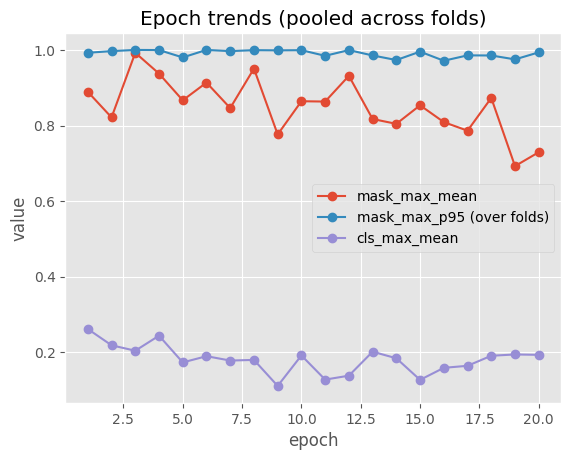

In [15]:
# --- Plots: mask_max_mean, mask_max_p95, cls_max_mean vs epoch ---

es_plot = epoch_summary.copy()

need = ["fold", "epoch", "mask_max_mean", "cls_max_mean"]
missing = [c for c in need if c not in es_plot.columns]
if missing:
    raise ValueError(f"epoch_summary missing required columns: {missing}")

# coerce numeric
for c in ["fold", "epoch", "mask_max_mean", "cls_max_mean"]:
    es_plot[c] = pd.to_numeric(es_plot[c], errors="coerce")

es_plot = es_plot.dropna(subset=["epoch", "mask_max_mean", "cls_max_mean"])

# aggregate across folds per epoch
g = es_plot.groupby("epoch", as_index=False).agg(
    mask_max_mean=("mask_max_mean", "mean"),
    mask_max_p95=("mask_max_mean", lambda s: s.quantile(0.95)),
    cls_max_mean=("cls_max_mean", "mean"),
)

plt.figure()
plt.plot(g["epoch"], g["mask_max_mean"], marker="o", label="mask_max_mean")
plt.plot(g["epoch"], g["mask_max_p95"], marker="o", label="mask_max_p95 (over folds)")
plt.plot(g["epoch"], g["cls_max_mean"], marker="o", label="cls_max_mean")
plt.xlabel("epoch")
plt.ylabel("value")
plt.title("Epoch trends (pooled across folds)")
plt.grid(True)
plt.legend()
plt.show()


In [16]:
# sanity_random_200 check

In [17]:
csvs = sorted(SAMPLEDUMP_ROOT.rglob("sanity_random_200.csv"))
assert csvs, "No sanity_random_200.csv found under sanity_dumps"

df = pd.read_csv(csvs[-1])

summary = {
    "rows": len(df),
    "forged_folder_rate": df["is_forged_folder"].mean(),
    "image_label_rate": df["image_label"].mean(),
    "any_instances_rate": (df["num_instances"] > 0).mean(),
    "mean_union_sum": df["union_sum"].mean(),
    "mean_max_instance_sum": df["max_instance_sum"].mean(),
}

display(pd.Series(summary, name="value").to_frame())


,value
rows,200.000
forged_folder_rate,0.545
image_label_rate,0.545
any_instances_rate,0.545
mean_union_sum,30973.545
mean_max_instance_sum,26154.455


In [18]:
# Cross-tab: are forged-folder images ever labeled authentic?
pd.crosstab(df["is_forged_folder"], df["image_label"])

image_label,0.0,1.0
is_forged_folder,,
False,91,0
True,0,109


In [19]:
# How often do we have forged-folder but zero instances?
df.query("is_forged_folder == True and num_instances == 0").shape[0]

0